In [1]:
import random
import numpy as np
import copy
from tabulate import tabulate
from typing import List
from scipy.stats import norm

def sphere(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(x**2)

def weierstrass(x, shift=None, a=0.5, b=3, kmax=20):
    if shift is not None:
        x = x - shift
    D = len(x)
    result = 0
    for i in range(D):
        result += np.sum([a**k * np.cos(2*np.pi*b**k*(x[i]+0.5)) for k in range(kmax)])
    result-=D*np.sum([a**k * np.cos(2*np.pi*b**k*(0.5)) for k in range(kmax)])
    return result

def weierstrass2(x, shift=None, a=0.5, b=3, kmax=20):
    if shift is not None:
        x = x - shift
    D = 25
    result = 0
    for i in range(D):
        result += np.sum([a**k * np.cos(2*np.pi*b**k*(x[i]+0.5)) for k in range(kmax)])
    result-=D*np.sum([a**k * np.cos(2*np.pi*b**k*(0.5)) for k in range(kmax)])
    return result

def rosenbrock(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def schwefel(x, shift=None):
    if shift is not None:
        x = x - shift
    return abs(418.9829*len(x)-np.sum(x * np.sin(np.sqrt(np.abs(x)))))

def griewank(x, shift=None):
    if shift is not None:
        x = x - shift
    part1 = np.sum(x**2)/4000
    part2 = np.prod(np.cos(x/np.sqrt(np.arange(1, len(x)+1))))
    return 1 + part1 - part2

def rastrigin(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(x**2 - 10 * np.cos(2 * np.pi * x) + 10)

def ackley(x, shift=None):
    if shift is not None:
        x = x - shift
    n = len(x)
    return -20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / n)) - np.exp(np.sum(np.cos(2 * np.pi * x) / n)) + 20 + np.exp(1)

In [2]:
class SubPopulation:

    def __init__(self, fitness_function, shift_vector, low, high):
        self.fitness_function = fitness_function
        self.shift_vector = shift_vector
        self.limit = [low, high]
        self.generation = [[random.uniform(low, high) for x in range(50)] for y in range(100)]
        self.covariance = np.cov(np.array(copy.copy(self.generation)).T)
        self.mean = np.mean(np.array(copy.copy(self.generation)), axis=0)
        self.variance = np.var(np.array(copy.copy(self.generation)), axis=0)
    
    def normal_distribution(self, x):
        tmp1 = ((2*np.pi)**(np.pi/2))*(np.sqrt(abs(np.linalg.det(self.covariance))))
        try:
            tmp2 = -1/2*(((x-self.mean).T) @ np.linalg.inv(self.covariance) @ (x-self.mean))
        except Exception:
            cov_matrix = self.covariance
            reg_cov_matrix = cov_matrix + (1e-9) * np.identity(cov_matrix.shape[0])
            tmp2 = -1/2*(((x-self.mean).T) @ np.linalg.inv(reg_cov_matrix) @ (x-self.mean))
            
        return (1/tmp1)*(np.exp(tmp2))

    def fitness(self, x):    
        return self.fitness_function(np.array(x), np.array(self.shift_vector))
    
    def crossover(self, x1, x2):
        son1 = copy.deepcopy(x1)
        son2 = copy.deepcopy(x2)
        rmp = random.uniform(0,1)

        if (rmp < 0.3):
            cross_over_point = random.randint(0, len(x1)-1)
            for k in range(cross_over_point, len(son1)):
                son1[k], son2[k] = son2[k], son1[k]

        elif (rmp<0.5):
            mean = copy.deepcopy(self.mean)
            var = copy.deepcopy(self.variance)
            for k in range(len(son1)):
                if norm.pdf(son1[k],  mean[k], np.sqrt(var[k])) < norm.pdf(son2[k],  mean[k], np.sqrt(var[k])):
                    son1[k], son2[k] = son2[k], son1[1]
        
        else:
            for k in range (len(son1)):
                popabiltity = random.uniform(0,1)
                if popabiltity<0.5:
                    tmp1 = son1[k] + random.uniform(0.1,2)*(son2[k]-son1[k])
                    tmp2 = son2[k] + random.uniform(0.1,2)*(son1[k]-son2[k])

                    if(tmp1 > self.limit[1]):
                        son1[k] = self.limit[1]
                    elif (tmp1 < self.limit[0]):
                        son1[k] = self.limit[0]
                    else:
                        son1[k] = tmp1

                    if(tmp2 > self.limit[1]):
                        son2[k] = self.limit[1]
                    elif (tmp2 < self.limit[0]):
                        son2[k] = self.limit[0]
                    else:
                        son2[k] = tmp2
        return son1, son2
    
    def mutation(self, x, eta_m = 20):
        son = copy.deepcopy(x)
        for k in range(len(son)):
            if random.uniform(0,1)<0.05:
                u = random.uniform(0, 1)
                delta = 0
                if u <= 0.5:
                    delta = (2*u)**(1/(eta_m+1)) - 1
                    son[k] = son[k] + delta*(son[k]-self.limit[0])
                else:
                    delta = 1 - (2*(1-u))**(1/(eta_m+1))
                    son[k] = son[k] + delta*(self.limit[1]-son[k])
        return son
        
    def update_population(self, next_generation):
        self.generation += next_generation
        self.generation.sort(key = lambda x: self.fitness(x))
        self.generation = self.generation[0:100]
        self.covariance = np.cov(np.array(copy.copy(self.generation)).T)
        self.mean = np.mean(np.array(copy.copy(self.generation)), axis=0)
        self.variance = np.var(np.array(copy.copy(self.generation)), axis=0)

    def generate_offspring(self):
        offspring = []
        for parent1 in range(50):
            rmp = random.uniform(0,1)
            if rmp > 0.3:
                parent2 = random.randint(0, len(self.generation)-1)

                son1, son2 = self.crossover(copy.deepcopy(self.generation[parent1]), copy.deepcopy(self.generation[parent2]))
                offspring.append(son1)
                offspring.append(son2)
            else:
                son = self.mutation(copy.deepcopy(self.generation[parent1]))
                offspring.append(son)
       
        return offspring

In [3]:
class Framework:

    def __init__(self, fitness_functions, shift_vectors, lows, highs, alpha) -> None:
        self.multi_task : List[SubPopulation] = []
        for k in range(len(fitness_functions)):
            self.multi_task.append(SubPopulation(fitness_functions[k], shift_vectors[k], lows[k], highs[k]))
        self.epsilon : List[float] = [1 for x in range(len(self.multi_task))]
        self.alpha = alpha
        self.number_effective_individual = [0 for x in range(len(fitness_functions))]
    
    def select_individuals_for_transfer(self, target):
        individuals = []
        for task in range(len(self.multi_task)):
            if task == target:
                continue
            transfer_individual = copy.deepcopy(self.multi_task[task].generation)
            for x in range(len(transfer_individual)):
                for k in range (len(transfer_individual[x])):
                    transfer_individual[x][k]/=self.multi_task[task].limit[1]
                    transfer_individual[x][k]*=self.multi_task[target].limit[1]
            individuals+=transfer_individual
        length = int(self.epsilon[target]*(len(self.multi_task)-1)*len(self.multi_task[target].generation))
    
        
        individuals.sort(key = lambda x: -self.multi_task[target].normal_distribution(np.array(x)))
        return individuals[0:length]

    def generate_next_generation(self):
        for k in range(len(self.multi_task)):
            offspring = self.multi_task[k].generate_offspring()
            self.multi_task[k].update_population(offspring)
            
            rmp = random.uniform(0,1)
            if rmp < self.alpha:
                if self.epsilon[k]>0.01:
                    transfer_individual = self.select_individuals_for_transfer(k)
                    transfer_individual.sort(key = lambda x: self.multi_task[k].fitness(x))
                    old_generation = copy.deepcopy(self.multi_task[k].generation)

                    next_generation = []
                    number_of_individual = 0
                    number_of_individual_transfer = 0
                    number_of_individual_not_transfer = 0
                    max_pop = len(self.multi_task[k].generation)

                    while (number_of_individual<max_pop):
                        if number_of_individual_transfer < len(transfer_individual) and self.multi_task[k].fitness(old_generation[number_of_individual_not_transfer]) > self.multi_task[k].fitness(transfer_individual[number_of_individual_transfer]):
                            next_generation.append(transfer_individual[number_of_individual_transfer])
                            number_of_individual_transfer+=1
                        else:
                            next_generation.append(old_generation[number_of_individual_not_transfer])
                            number_of_individual_not_transfer+=1
                        number_of_individual+=1
                    
                    self.epsilon[k]=number_of_individual_transfer/len(transfer_individual)
                    self.number_effective_individual[k]+=number_of_individual_transfer
                    
                    self.multi_task[k].generation=next_generation
                    self.multi_task[k].covariance = np.cov(np.array(copy.copy(self.multi_task[k].generation)).T)
                    self.multi_task[k].mean = np.mean(np.array(copy.copy(self.multi_task[k].generation)), axis=0)
                    self.multi_task[k].variance = np.var(np.array(copy.copy(self.multi_task[k].generation)), axis=0)
                else:
                    self.epsilon[k]+=0.002

In [4]:
finess_functions = []
shift_vectors = []
lows = []
highs = []

#Sphere 1:
finess_functions.append(sphere)
shift_vectors.append([0 for x in range(50)])
lows.append(-100)
highs.append(100)

#Sphere 2:
finess_functions.append(sphere)
shift_vectors.append([80 for x in range(50)])
lows.append(-100)
highs.append(100)

#Sphere 3:
finess_functions.append(sphere)
shift_vectors.append([-80 for x in range(50)])
lows.append(-100)
highs.append(100)

#Weierstrass 1:
finess_functions.append(weierstrass2)
shift_vectors.append([-0.4 for x in range(50)])
lows.append(-0.5)
highs.append(0.5)

#Rosenbrock:
finess_functions.append(rosenbrock)
shift_vectors.append([0 for x in range(50)])
lows.append(-50)
highs.append(50)

#Ackley:
finess_functions.append(ackley)
shift_vectors.append([40 for x in range(50)])
lows.append(-50)
highs.append(50)

#Weierstrass 2:
finess_functions.append(weierstrass)
shift_vectors.append([0.4 for x in range(50)])
lows.append(-0.5)
highs.append(0.5)

#Schwefel:
finess_functions.append(schwefel)
shift_vectors.append([420.9687 for x in range(50)])
lows.append(-500)
highs.append(500)

#Griewank:
finess_functions.append(griewank)
shift_vectors.append([-80 for x in range(25)]+[80 for x in range(25)])
lows.append(-100)
highs.append(100)

#Rastrign:
finess_functions.append(rastrigin)
shift_vectors.append([40 for x in range(25)]+[-40 for x in range(25)])
lows.append(-50)
highs.append(50)


In [5]:

model = Framework(finess_functions, shift_vectors, lows, highs, 0.1)
history = []
for x in range(1000):
    model.generate_next_generation()
    tmp = []
    for k in range(len(model.multi_task)):
        tmp.append(model.multi_task[k].fitness(model.multi_task[k].generation[0]))
    history.append(tmp)


c:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\DELL\AppData\Local\Temp\ipykernel_4372\3421876413.py:21: RuntimeWarning: overflow encountered in exp
  return (1/tmp1)*(np.exp(tmp2))
C:\Users\DELL\AppData\Local\Temp\ipykernel_4372\3421876413.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  return (1/tmp1)*(np.exp(tmp2))
C:\Users\DELL\AppData\Local\Temp\ipykernel_4372\3421876413.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  return (1/tmp1)*(np.exp(tmp2))


In [6]:
headers = [f"T{i+1}" for i in range(len(history[0]))]
table = tabulate(history, headers=headers, tablefmt='grid')
print(table)

+----------------+------------------+-----------------+----------+------------------+--------------+----------+----------------+-------------+------------+
|             T1 |               T2 |              T3 |       T4 |               T5 |           T6 |       T7 |             T8 |          T9 |        T10 |
+================+==================+=================+==========+==================+==============+==========+================+=============+============+
| 62966.7        | 318701           | 249653          | 30.0749  |      1.08261e+09 | 20.9777      | 81.8183  | 6178.27        | 75.7383     | 78811.9    |
+----------------+------------------+-----------------+----------+------------------+--------------+----------+----------------+-------------+------------+
| 26971.1        | 306252           | 217079          | 28.0247  |      5.6209e+08  | 20.8216      | 79.2771  | 3087.87        | 75.7383     | 65409.4    |
+----------------+------------------+-----------------+---------

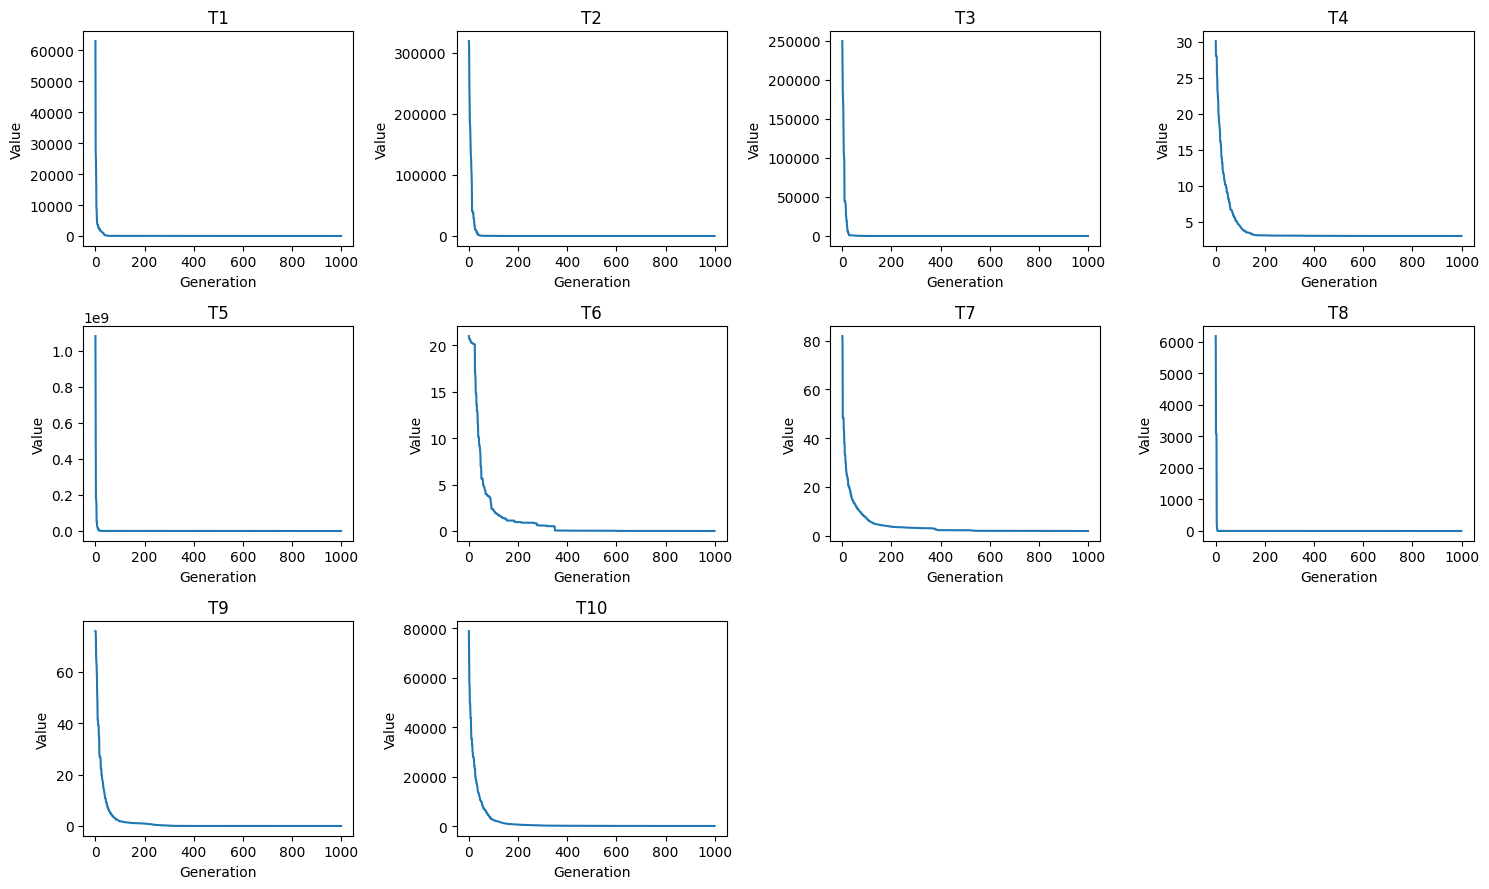

In [7]:
import matplotlib.pyplot as plt

def plot_functions(history):
    num_functions = len(history[0])  # Số lượng hàm
    num_points = len(history)  # Số lượng điểm
    num_plots_per_row = 4  # Số lượng đồ thị trên mỗi hàng

    num_rows = (num_functions + num_plots_per_row - 1) // num_plots_per_row

    # Tạo subplot với kích thước phù hợp
    fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(15, num_rows*3))

    for j in range(num_functions):
        row_index = j // num_plots_per_row
        col_index = j % num_plots_per_row
        axs[row_index, col_index].plot(range(num_points), history[:, j])
        axs[row_index, col_index].set_title(f'T{j+1}')
        axs[row_index, col_index].set_xlabel('Generation')
        axs[row_index, col_index].set_ylabel('Value')

    # Nếu số lượng hàm không phải là bội số của num_plots_per_row, ẩn các subplot không cần thiết
    for j in range(num_functions, num_rows*num_plots_per_row):
        row_index = j // num_plots_per_row
        col_index = j % num_plots_per_row
        axs[row_index, col_index].axis('off')

    plt.tight_layout()
    plt.show()


plot_functions(np.array(history))


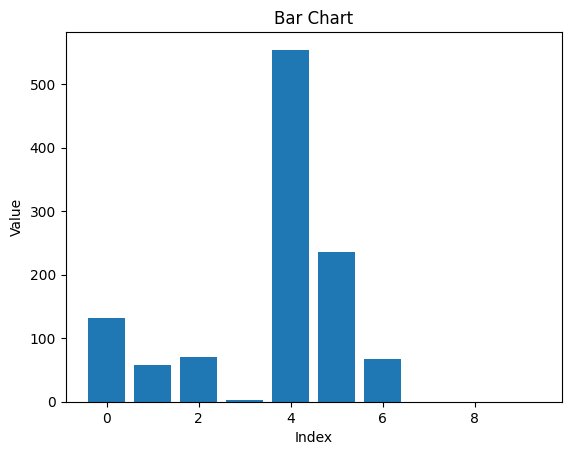

[132, 58, 71, 3, 554, 235, 67, 0, 0, 0]


In [8]:
import matplotlib.pyplot as plt

def plot_bar_chart(data):
    # Tạo biểu đồ cột từ dữ liệu
    plt.bar(range(len(data)), data)
    
    # Đặt nhãn cho trục x và trục y
    plt.xlabel('Index')
    plt.ylabel('Value')
    
    # Đặt tiêu đề cho biểu đồ
    plt.title('Bar Chart')
    
    # Hiển thị biểu đồ
    plt.show()

plot_bar_chart(model.number_effective_individual)
print(model.number_effective_individual)